In [1]:
# Manipulação de arquivos, arrays e dados
import os, random
import numpy as np
import pandas as pd
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Treinamento com mixed precision
from torch.cuda.amp import autocast, GradScaler

# Modelos pré-treinados
import torchvision.models as models
from torchvision.models import ResNet34_Weights

# Visualização
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Equivalência 2024 → 2020
seq_map_2024_to_2020 = {
    "t1n": "t1"
}

# Configurações
CROSSDATASET = r"C:\Users\dados\Documents\mini_datasets\crossdataset"
SEQ = "t1n"
MASK = "seg"
BATCH_SIZE = 32

# Dataset
class CrossDataset(Dataset):
    def __init__(self, meta_csv, seq, mask="seg"):
        self.meta = pd.read_csv(meta_csv)
        seq_std = seq_map_2024_to_2020.get(seq, seq)

        # usa seq_std se existir no CSV, caso contrário usa seq original
        if seq_std in self.meta.columns:
            self.seq_std = seq_std
        elif seq in self.meta.columns:
            self.seq_std = seq
        else:
            raise KeyError(
                f"Nenhuma coluna correspondente encontrada no CSV {meta_csv}. "
                f"Procurado: {seq_std} ou {seq}. "
                f"Colunas disponíveis: {self.meta.columns.tolist()}"
            )

        self.mask = mask

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        x = np.load(os.path.join(CROSSDATASET, row[self.seq_std]))
        y = np.load(os.path.join(CROSSDATASET, row[self.mask]))

        x = x.astype(np.float32)
        if x.max() > 0:
            x = x / x.max()

        x = np.expand_dims(x, axis=0)
        y = np.expand_dims(y.astype(np.uint8), axis=0)

        return torch.from_numpy(x), torch.from_numpy(y)


# Instanciando datasets
train_csv = os.path.join(CROSSDATASET, "metadata_cross_train.csv")
val_csv   = os.path.join(CROSSDATASET, "metadata_cross_val.csv")
test_csv  = os.path.join(CROSSDATASET, "metadata_cross_test.csv")

train_dataset = CrossDataset(train_csv, seq=SEQ, mask=MASK)
val_dataset   = CrossDataset(val_csv,   seq=SEQ, mask=MASK)
test_dataset  = CrossDataset(test_csv,  seq=SEQ, mask=MASK)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Verificação CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Dispositivo usado: {device} ({gpu_name})")
else:
    device = torch.device("cpu")
    print("Dispositivo usado: CPU")


Dispositivo usado: cuda (NVIDIA GeForce RTX 4070 SUPER)


In [3]:
# Resumo em DataFrame
summary = []
for name, dataset, loader in [
    ("train", train_dataset, train_loader),
    ("val",   val_dataset,   val_loader),
    ("test",  test_dataset,  test_loader),
]:
    images, masks = next(iter(loader))
    summary.append({
        "split": name,
        "total_t1": len(dataset),
        "total_seg": len(dataset),
        "img_shape (T1)": tuple(images.shape[1:]),
        "mask_shape (Seg)": tuple(masks.shape[1:])
    })

df_summary = pd.DataFrame(summary)
display(df_summary)


,split,total_t1,total_seg,img_shape (T1),mask_shape (Seg)
0,train,4320,4320,"(1, 240, 240)","(1, 240, 240)"
1,val,1080,1080,"(1, 240, 240)","(1, 240, 240)"
2,test,1400,1400,"(1, 240, 240)","(1, 240, 240)"


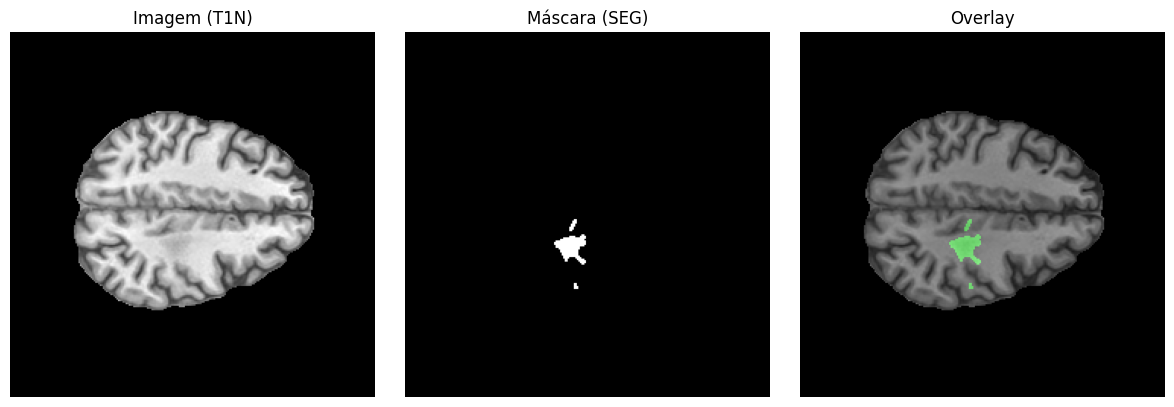

Paciente exibido: BraTS-GLI-02914-101 | Split: val | Slice: 3


In [4]:
# Escolha do dataset
BASE_PATH = CROSSDATASET
MASK_SEQ = "seg"

# Sorteio do split e do paciente
splits = ["train", "val", "test"]
split_escolhido = random.choice(splits)

split_dir = os.path.join(BASE_PATH, split_escolhido)
pacientes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
assert len(pacientes) > 0, f"Nenhum paciente encontrado no split {split_escolhido}!"
paciente_escolhido = random.choice(pacientes)

# Ajuste de equivalências
aliases = [SEQ, seq_map_2024_to_2020.get(SEQ, SEQ)]
aliases = list(dict.fromkeys(aliases))  # remove duplicados

img_dir = None
for alias in aliases:
    candidate = os.path.join(split_dir, paciente_escolhido, alias)
    if os.path.isdir(candidate):
        img_dir = candidate
        break
assert img_dir is not None, f"Nenhuma pasta encontrada para {SEQ} em {paciente_escolhido}!"

mask_dir = os.path.join(split_dir, paciente_escolhido, MASK_SEQ)
assert os.path.isdir(mask_dir), f"Nenhuma pasta de máscara encontrada em {paciente_escolhido}!"

# Carregar arquivos
img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".npy")])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".npy")])
assert len(img_files) > 0, "Nenhuma slice encontrada para o paciente sorteado!"

# Sorteio de 1 slice
idx = random.choice(range(len(img_files)))
img = np.load(img_files[idx])
mask = np.load(mask_files[idx])

plt.figure(figsize=(12, 4))

# Imagem
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title(f"Imagem ({SEQ.upper()})")
plt.axis("off")

# Máscara
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Máscara (SEG)")
plt.axis("off")

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
green_layer = np.zeros((*mask.shape, 3), dtype=np.float32)
green_layer[..., 1] = mask / mask.max() if mask.max() > 0 else mask
plt.imshow(green_layer, alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Paciente exibido: {paciente_escolhido} | Split: {split_escolhido} | Slice: {idx}")


In [5]:
# Dataset customizado para crossdataset
class CrossDataset(Dataset):
    def __init__(self, meta_csv, base_path, seq="t1n", mask="seg", size=(240,240), binarize=True):
        self.meta = pd.read_csv(meta_csv)
        self.base_path = base_path
        self.seq = seq
        self.mask = mask
        self.size = size
        self.binarize = binarize

        # converte para padrão 2020 (se seq for 2024)
        seq_std = seq_map_2024_to_2020.get(seq, seq)

        # valida se existe no CSV
        if seq_std in self.meta.columns:
            self.seq_std = seq_std
        elif seq in self.meta.columns:
            self.seq_std = seq
        else:
            raise KeyError(
                f"Nenhuma coluna encontrada para {seq} ou {seq_std} em {meta_csv}. "
                f"Colunas disponíveis: {self.meta.columns.tolist()}"
            )

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]

        # Carregar imagem e máscara
        img  = np.load(os.path.join(self.base_path, row[self.seq_std]))
        mask = np.load(os.path.join(self.base_path, row[self.mask]))

        # Normalizar imagem
        img = img.astype(np.float32)
        if img.max() > 0:
            img = img / img.max()

        # Normalizar máscara
        mask = mask.astype(np.float32)
        if self.binarize:
            mask = (mask > 0.5).astype(np.float32)

        # Redimensionar se necessário
        if img.shape != self.size:
            img  = cv2.resize(img,  self.size, interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)

        # Tensores [C,H,W]
        img_t  = torch.from_numpy(img).unsqueeze(0)
        mask_t = torch.from_numpy(mask).unsqueeze(0)

        return img_t, mask_t

# Instanciando para treino, validação e teste
IMG_SIZE = (240,240)
train_dataset = CrossDataset(train_csv, CROSSDATASET, seq="t1n", mask="seg", size=IMG_SIZE)
val_dataset   = CrossDataset(val_csv,   CROSSDATASET, seq="t1n", mask="seg", size=IMG_SIZE)
test_dataset  = CrossDataset(test_csv,  CROSSDATASET, seq="t1n", mask="seg", size=IMG_SIZE)

# Usando os CSVs para contar pacientes/slices
splits = {
    "Treino": train_csv,
    "Validação": val_csv,
    "Teste": test_csv
}

data = []
for nome, csv_path in splits.items():
    data.append({
        "Split": nome,
        "Caminho": csv_path
    })

df_splits_2024 = pd.DataFrame(data, columns=["Split", "Caminho"])
pd.set_option("display.max_colwidth", None)  # não cortar caminhos
display(df_splits_2024)

,Split,Caminho
0,Treino,C:\Users\dados\Documents\mini_datasets\crossdataset\metadata_cross_train.csv
1,Validação,C:\Users\dados\Documents\mini_datasets\crossdataset\metadata_cross_val.csv
2,Teste,C:\Users\dados\Documents\mini_datasets\crossdataset\metadata_cross_test.csv


In [6]:
# Blocos auxiliares
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=p_drop),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.0):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch=out_ch*2, out_ch=out_ch, p_drop=p_drop)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


# Modelo ResNet + U-Net decoder
class ResNetUNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1,
                 pretrained=True, freeze_encoder=False,
                 return_logits=True, p_drop=0.0):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet34(weights=weights)

        # Conv1 adaptada para grayscale
        if n_channels != 3:
            old_conv = self.backbone.conv1
            self.backbone.conv1 = nn.Conv2d(
                n_channels, old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=False
            )
            if pretrained:
                with torch.no_grad():
                    if n_channels == 1:
                        self.backbone.conv1.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
                    else:
                        rep = (n_channels + 2) // 3
                        w = old_conv.weight.repeat(1, rep, 1, 1)[:, :n_channels]
                        self.backbone.conv1.weight[:] = w / (3.0 / n_channels)

        # Congela encoder se solicitado
        if freeze_encoder:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Decoder U-Net
        self.up4 = UpBlock(512, 256, p_drop=p_drop)
        self.up3 = UpBlock(256, 128, p_drop=p_drop)
        self.up2 = UpBlock(128, 64,  p_drop=p_drop)
        self.up1 = UpBlock(64,  64,  p_drop=p_drop)

        self.final_up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        self.return_logits = return_logits

    def encode(self, x):
        x0 = self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        x1 = self.backbone.layer1(self.backbone.maxpool(x0))
        x2 = self.backbone.layer2(x1)
        x3 = self.backbone.layer3(x2)
        x4 = self.backbone.layer4(x3)
        return x0, x1, x2, x3, x4

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encode(x)
        x = self.up4(x4, x3)
        x = self.up3(x,  x2)
        x = self.up2(x,  x1)
        x = self.up1(x,  x0)
        x = self.final_up(x)
        logits = self.out_conv(x)
        return logits if self.return_logits else torch.sigmoid(logits)


# Instanciando modelo
DROPOUT_P = 0.2
model = ResNetUNet(
    n_channels=1,
    n_classes=1,
    pretrained=True,
    freeze_encoder=False,
    return_logits=True,
    p_drop=DROPOUT_P
).to(device)


In [7]:
# Métricas
@torch.no_grad()
def dice_coeff_hard(logits_or_probs, target, threshold=0.5, eps=1e-6, from_logits=True):
    probs = torch.sigmoid(logits_or_probs) if from_logits else logits_or_probs
    target = target.float().to(probs.device)
    preds = (probs > threshold).float()
    if preds.shape[-2:] != target.shape[-2:]:
        preds = F.interpolate(preds, size=target.shape[-2:], mode="nearest")
    dims = (1, 2, 3)
    inter = (preds * target).sum(dims)
    denom = preds.sum(dims) + target.sum(dims)
    return ((2 * inter + eps) / (denom + eps)).mean()

def dice_coeff_soft(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    target = target.float()
    if probs.shape[-2:] != target.shape[-2:]:
        probs = F.interpolate(probs, size=target.shape[-2:], mode="bilinear", align_corners=False)
    dims = (1, 2, 3)
    inter = (probs * target).sum(dims)
    denom = probs.sum(dims) + target.sum(dims)
    return ((2 * inter + eps) / (denom + eps)).mean()

@torch.no_grad()
def iou_hard(logits_or_probs, target, thr=0.5, eps=1e-6, from_logits=True):
    probs = torch.sigmoid(logits_or_probs) if from_logits else logits_or_probs
    preds = (probs > thr).float()
    target = (target > 0).float().to(preds.device)

    # ignora só a dimensão batch (0)
    dims = tuple(range(1, preds.ndim))

    inter = (preds * target).sum(dims)
    union = preds.sum(dims) + target.sum(dims) - inter
    return ((inter + eps) / (union + eps)).mean()

# Loss combinada BCE + Dice
class BCEWithLogitsDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5, pos_weight=None):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.bw = bce_weight
        self.dw = dice_weight

    def forward(self, logits, target):
        target = target.float()
        return (
            self.bw * self.bce(logits, target) +
            self.dw * (1.0 - dice_coeff_soft(logits, target))
        )


In [8]:
# Configurações de treino
LR = 1e-3
WEIGHT_DECAY = 1e-5

# Loss + Optimizer + Scheduler
criterion = BCEWithLogitsDiceLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6
)

# Mixed precision (AMP)
scaler = GradScaler(enabled=(device=="cuda"))

print(f"Treino Crossdataset - T1/T1n | "
      f"Treino: {len(train_dataset)}, "
      f"Validação: {len(val_dataset)}, "
      f"Teste: {len(test_dataset)}")


Treino Crossdataset - T1/T1n | Treino: 4320, Validação: 1080, Teste: 1400


C:\Users\dados\anaconda3\envs\Torch\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\dados\AppData\Local\Temp\ipykernel_23872\1897015401.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=="cuda"))


In [9]:
# Funções auxiliares
def random_aug(imgs, masks):
    if torch.rand(1) < 0.5:  # flip horizontal
        imgs, masks = torch.flip(imgs, dims=[3]), torch.flip(masks, dims=[3])
    if torch.rand(1) < 0.5:  # flip vertical
        imgs, masks = torch.flip(imgs, dims=[2]), torch.flip(masks, dims=[2])
    if torch.rand(1) < 0.25:  # rotação 90°
        imgs, masks = imgs.transpose(2,3), masks.transpose(2,3)
    return imgs, masks

class EarlyStopping:
    def __init__(self, patience=8):
        self.best, self.count, self.best_state = None, 0, None
        self.patience = patience
    def step(self, metric, model):
        if (self.best is None) or (metric < self.best):
            self.best, self.count = metric, 0
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            return True
        else:
            self.count += 1
            return False
    def should_stop(self): return self.count >= self.patience

def set_encoder_trainable(m, flag: bool):
    for p in m.backbone.parameters():
        p.requires_grad = flag

# Treinamento
N_EPOCHS = 80
early = EarlyStopping(patience=8)

for epoch in range(N_EPOCHS):
    set_encoder_trainable(model, flag=(epoch >= 2))  # warmup encoder

    # Treino
    model.train()
    train_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        imgs, masks = random_aug(imgs, masks)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, masks)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validação
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            val_loss += criterion(logits, masks).item()
            val_dice += dice_coeff_hard(logits, masks, threshold=0.5, from_logits=True).item()

    train_loss /= max(1, len(train_loader))
    val_loss   /= max(1, len(val_loader))
    val_dice   /= max(1, len(val_loader))

    print(f"Epoch {epoch+1:02d}/{N_EPOCHS} | "
          f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_dice={val_dice:.4f}")

    scheduler.step(val_loss)
    improved = early.step(val_loss, model)
    if early.should_stop():
        print("⏹ Early stopping acionado.")
        break

# Carrega melhor estado
if early.best_state is not None:
    model.load_state_dict(early.best_state)
    model.to(device)
    print("✅ Melhor modelo carregado (menor val_loss).")


C:\Users\dados\AppData\Local\Temp\ipykernel_23872\2950497543.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):


Epoch 01/80 | train_loss=0.4137 | val_loss=0.3338 | val_dice=0.4852
Epoch 02/80 | train_loss=0.3030 | val_loss=0.2922 | val_dice=0.5056
Epoch 03/80 | train_loss=0.2909 | val_loss=0.3176 | val_dice=0.4517
Epoch 04/80 | train_loss=0.2522 | val_loss=0.2572 | val_dice=0.5464
Epoch 05/80 | train_loss=0.2355 | val_loss=0.2729 | val_dice=0.5185
Epoch 06/80 | train_loss=0.2285 | val_loss=0.2334 | val_dice=0.5886
Epoch 07/80 | train_loss=0.2171 | val_loss=0.2819 | val_dice=0.5090
Epoch 08/80 | train_loss=0.2146 | val_loss=0.2366 | val_dice=0.5802
Epoch 09/80 | train_loss=0.2078 | val_loss=0.2240 | val_dice=0.6010
Epoch 10/80 | train_loss=0.2057 | val_loss=0.2632 | val_dice=0.5420
Epoch 11/80 | train_loss=0.2043 | val_loss=0.2302 | val_dice=0.5960
Epoch 12/80 | train_loss=0.2036 | val_loss=0.2482 | val_dice=0.5678
Epoch 13/80 | train_loss=0.2010 | val_loss=0.2198 | val_dice=0.6110
Epoch 14/80 | train_loss=0.1962 | val_loss=0.2395 | val_dice=0.5755
Epoch 15/80 | train_loss=0.1974 | val_loss=0.220

Amostra de teste escolhida: idx=744
Dice: 0.7961 | IoU: 0.6613


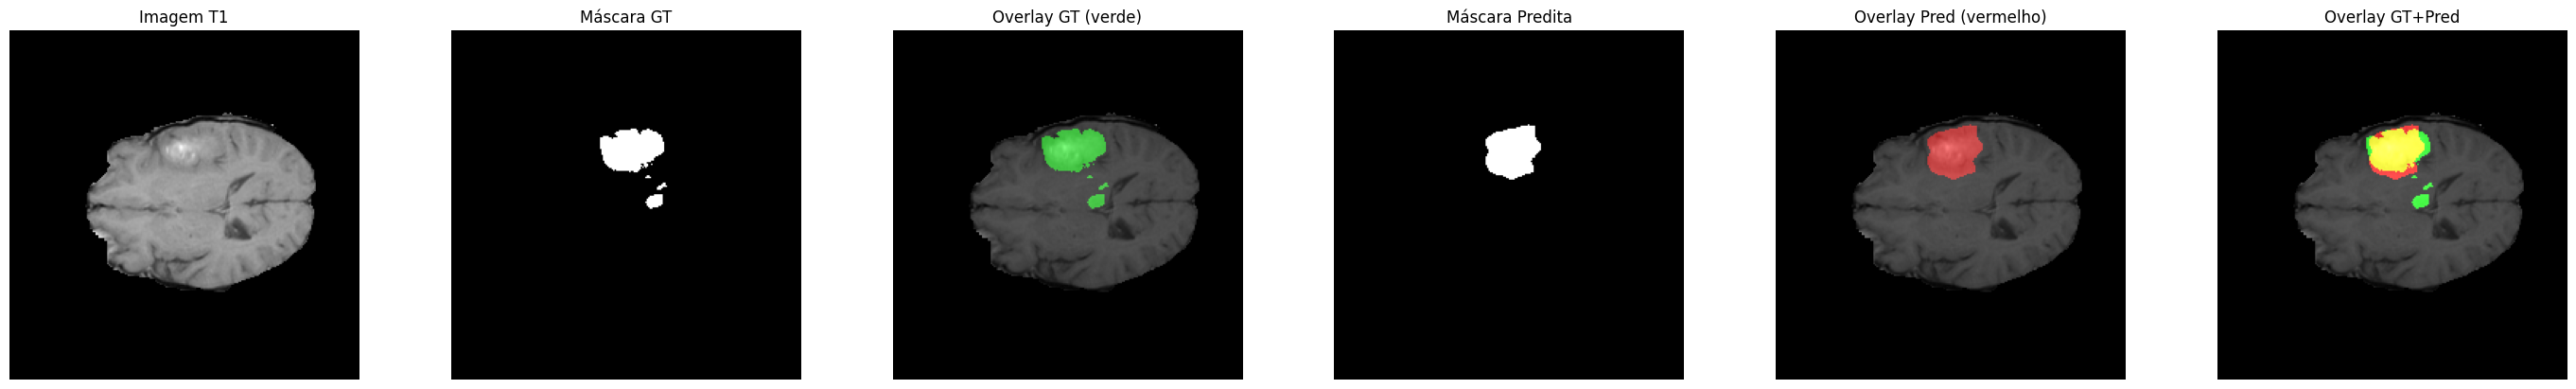

In [13]:
# Teste no baseline2020
model.eval()
idx = random.randrange(len(test_dataset))
img, mask = test_dataset[idx]
print(f"Amostra de teste escolhida: idx={idx}")

with torch.no_grad():
    logit = model(img.unsqueeze(0).to(device))
    prob  = torch.sigmoid(logit).cpu()
pred_bin = (prob > 0.5).float()

# Métricas
dice = dice_coeff_hard(prob, mask.unsqueeze(0), threshold=0.5, from_logits=False).item()
iou = iou_hard(pred_bin, mask.unsqueeze(0), thr=0.5, from_logits=False).item()
print(f"Dice: {dice:.4f} | IoU: {iou:.4f}")

# Funções de overlay
def overlay_color(img_01CHW, mask_01CHW, color=(0,1,0), alpha=0.5):
    img2d  = img_01CHW.squeeze().cpu().numpy().astype(np.float32)
    mask2d = mask_01CHW.squeeze().cpu().numpy().astype(np.float32)
    img_rgb = np.stack([img2d]*3, axis=-1)
    color_img = np.zeros_like(img_rgb, dtype=np.float32)
    for c in range(3):
        color_img[..., c] = color[c] * mask2d
    return np.clip(img_rgb*(1-alpha) + color_img*alpha, 0, 1)

def overlay_both(img_01CHW, gt_01CHW, pred_01CHW, alpha_img=0.5, alpha_masks=0.7):
    img2d = img_01CHW.squeeze().cpu().numpy().astype(np.float32)
    gt2d  = gt_01CHW.squeeze().cpu().numpy().astype(np.float32)
    pr2d  = pred_01CHW.squeeze().cpu().numpy().astype(np.float32)
    img_rgb = np.stack([img2d]*3, axis=-1)
    color = np.zeros_like(img_rgb, dtype=np.float32)
    color[..., 0] = pr2d
    color[..., 1] = gt2d
    return np.clip(img_rgb*alpha_img + color*alpha_masks, 0, 1)

# Criar overlays
overlay_gt_green = overlay_color(img, mask,               color=(0,1,0), alpha=0.5)
overlay_pred_red = overlay_color(img, pred_bin.squeeze(0),color=(1,0,0), alpha=0.5)
overlay_combo    = overlay_both (img, mask, pred_bin.squeeze(0))

# Plot
fig, axes = plt.subplots(1, 6, figsize=(28, 4), constrained_layout=True)
axes[0].imshow(img.squeeze(),  cmap="gray");     axes[0].set_title("Imagem T1");            axes[0].axis("off")
axes[1].imshow(mask.squeeze(), cmap="gray");     axes[1].set_title("Máscara GT");           axes[1].axis("off")
axes[2].imshow(overlay_gt_green);                axes[2].set_title("Overlay GT (verde)");   axes[2].axis("off")
axes[3].imshow(pred_bin.squeeze(), cmap="gray"); axes[3].set_title("Máscara Predita");      axes[3].axis("off")
axes[4].imshow(overlay_pred_red);                axes[4].set_title("Overlay Pred (vermelho)"); axes[4].axis("off")
axes[5].imshow(overlay_combo);                   axes[5].set_title("Overlay GT+Pred");      axes[5].axis("off")
plt.show()


Exibindo: Melhor, Melhor, Aleatório x4, Pior, Pior


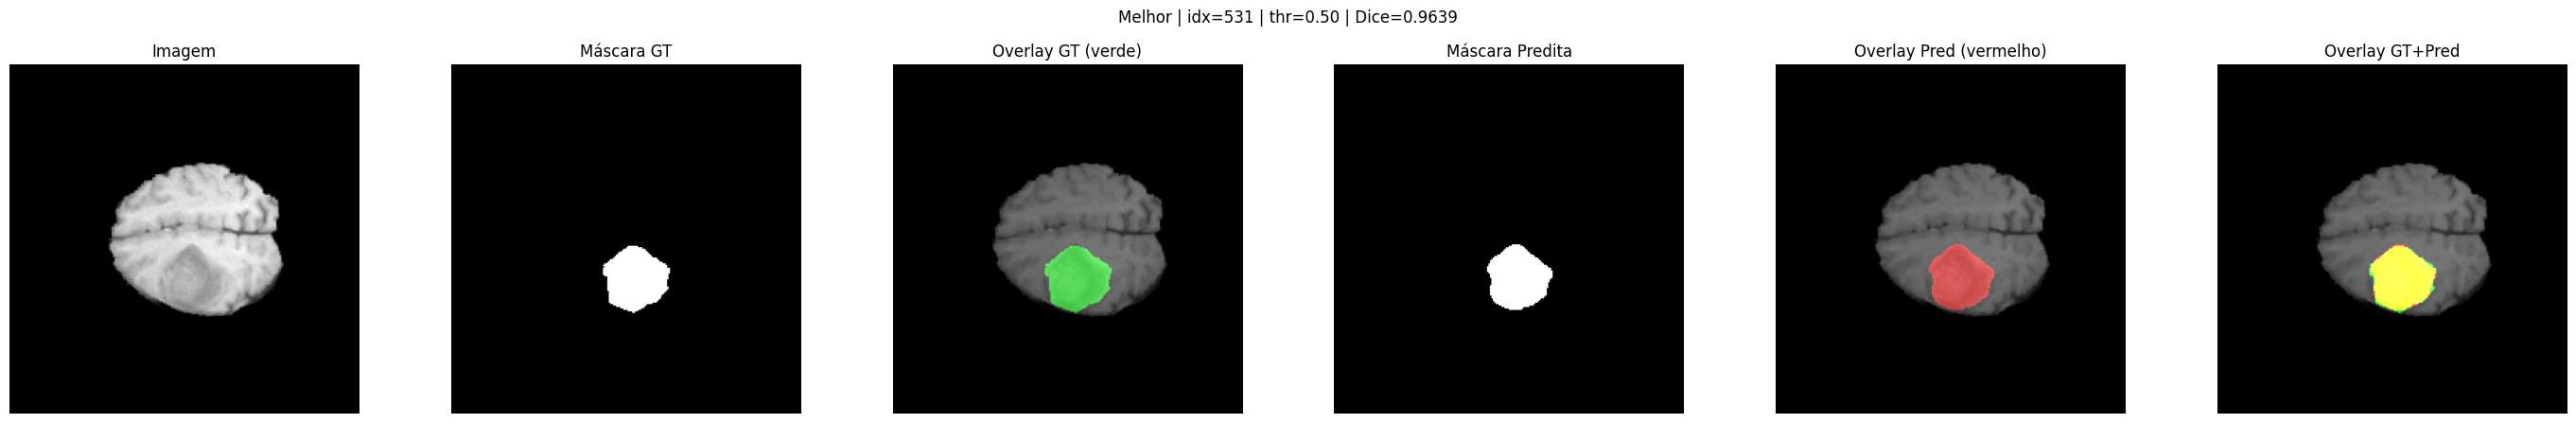

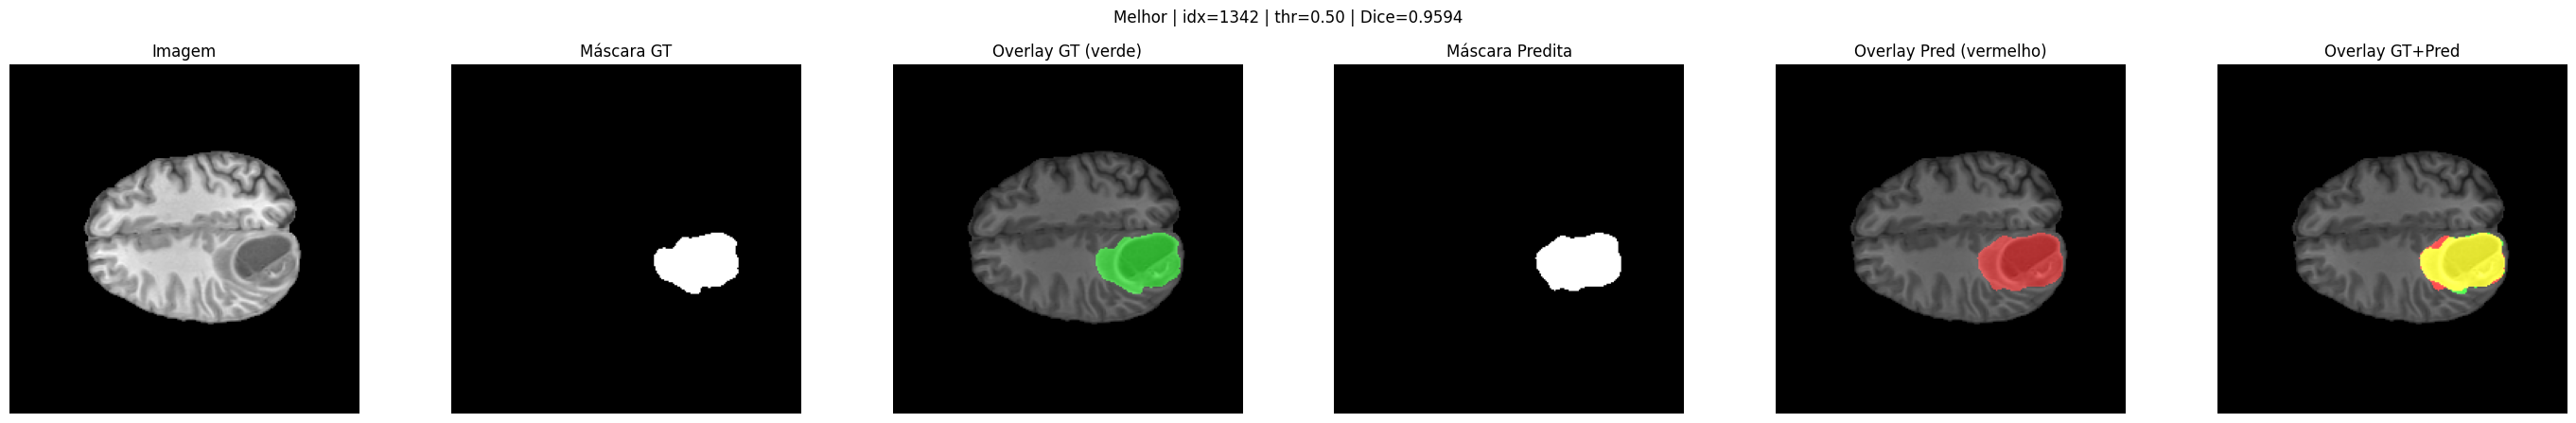

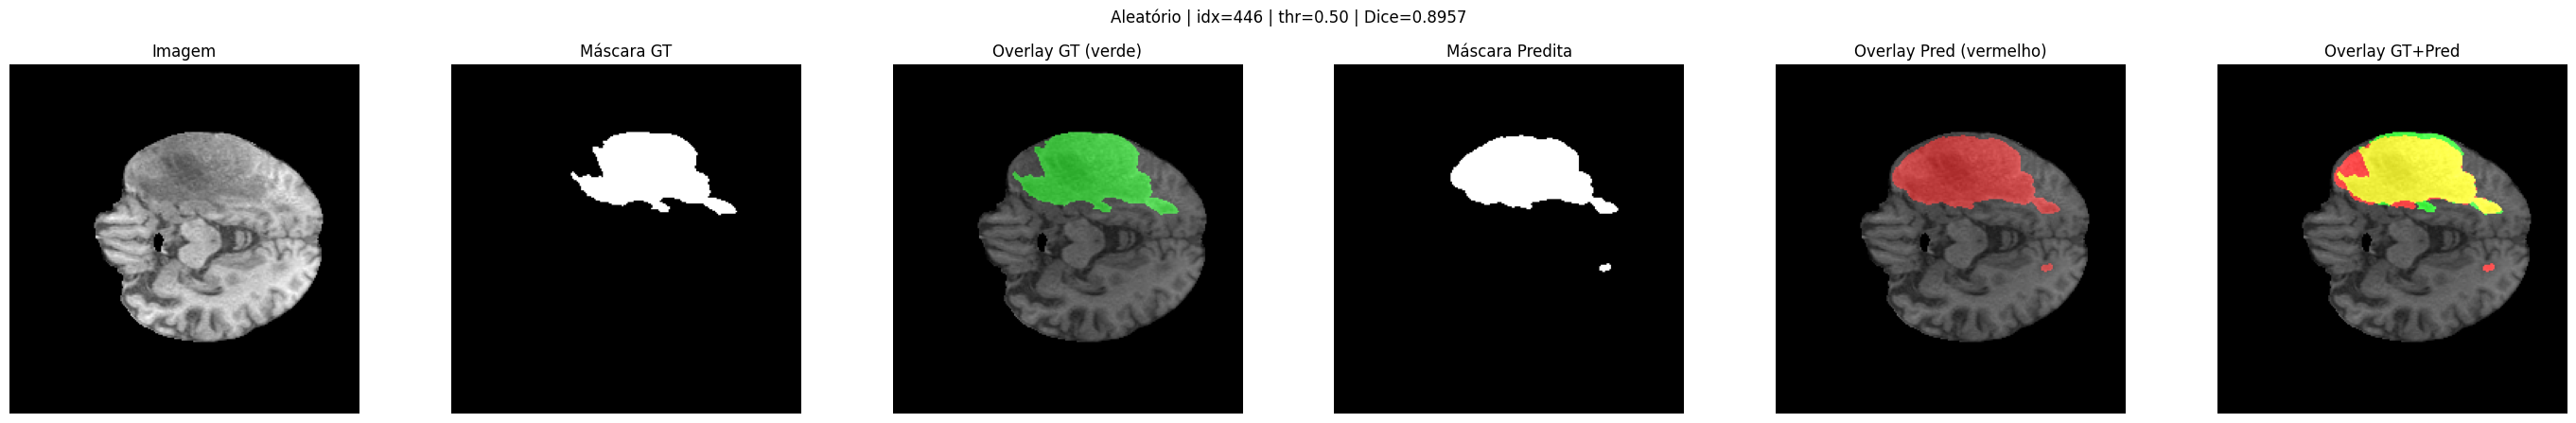

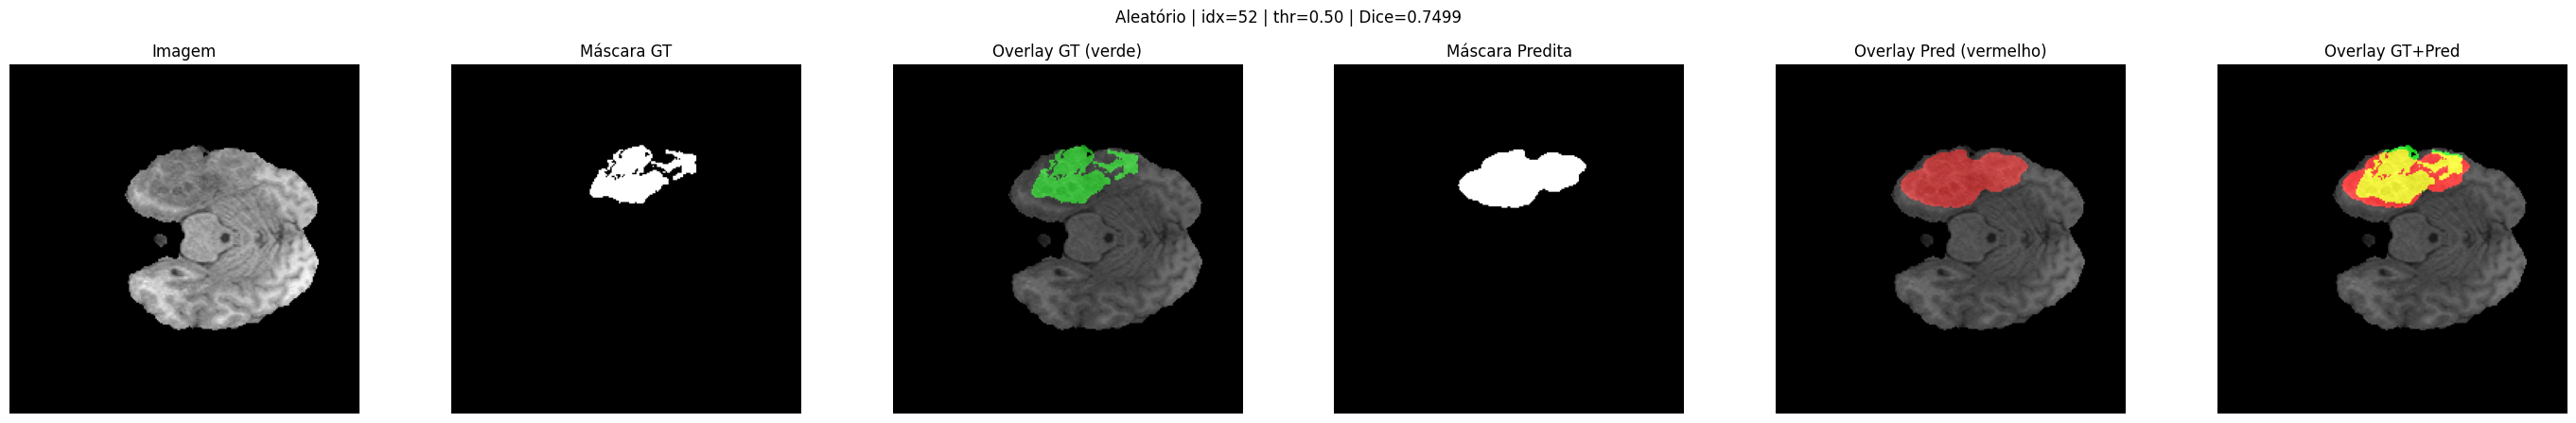

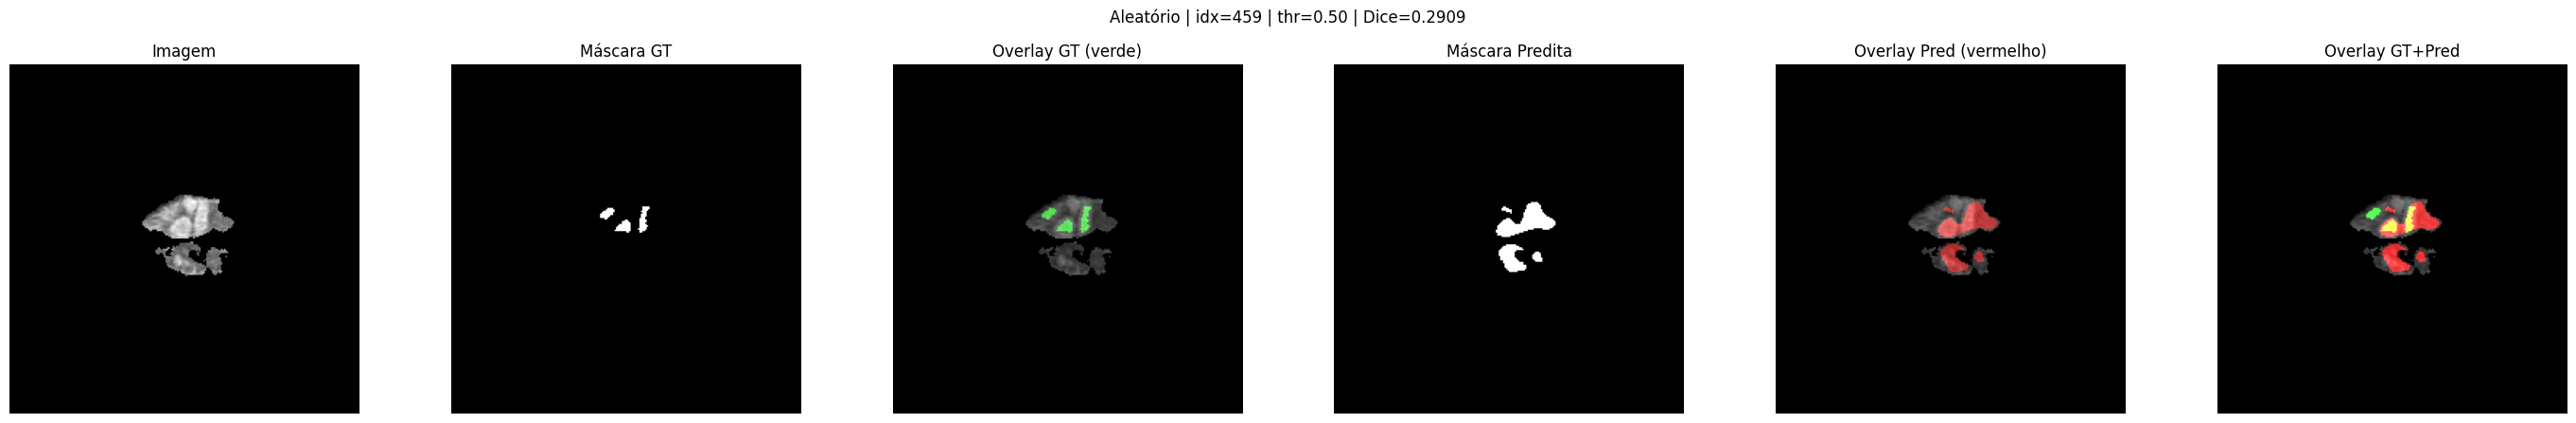

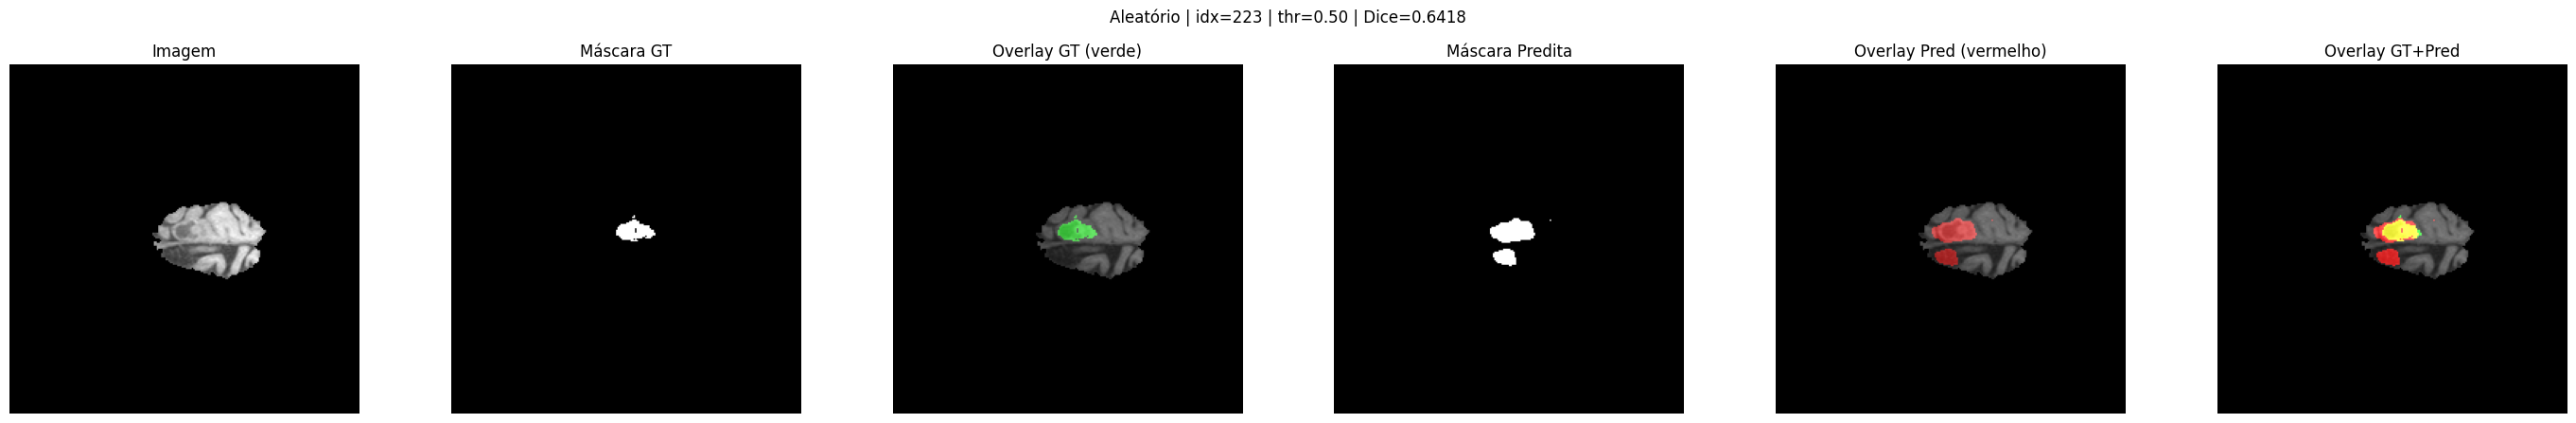

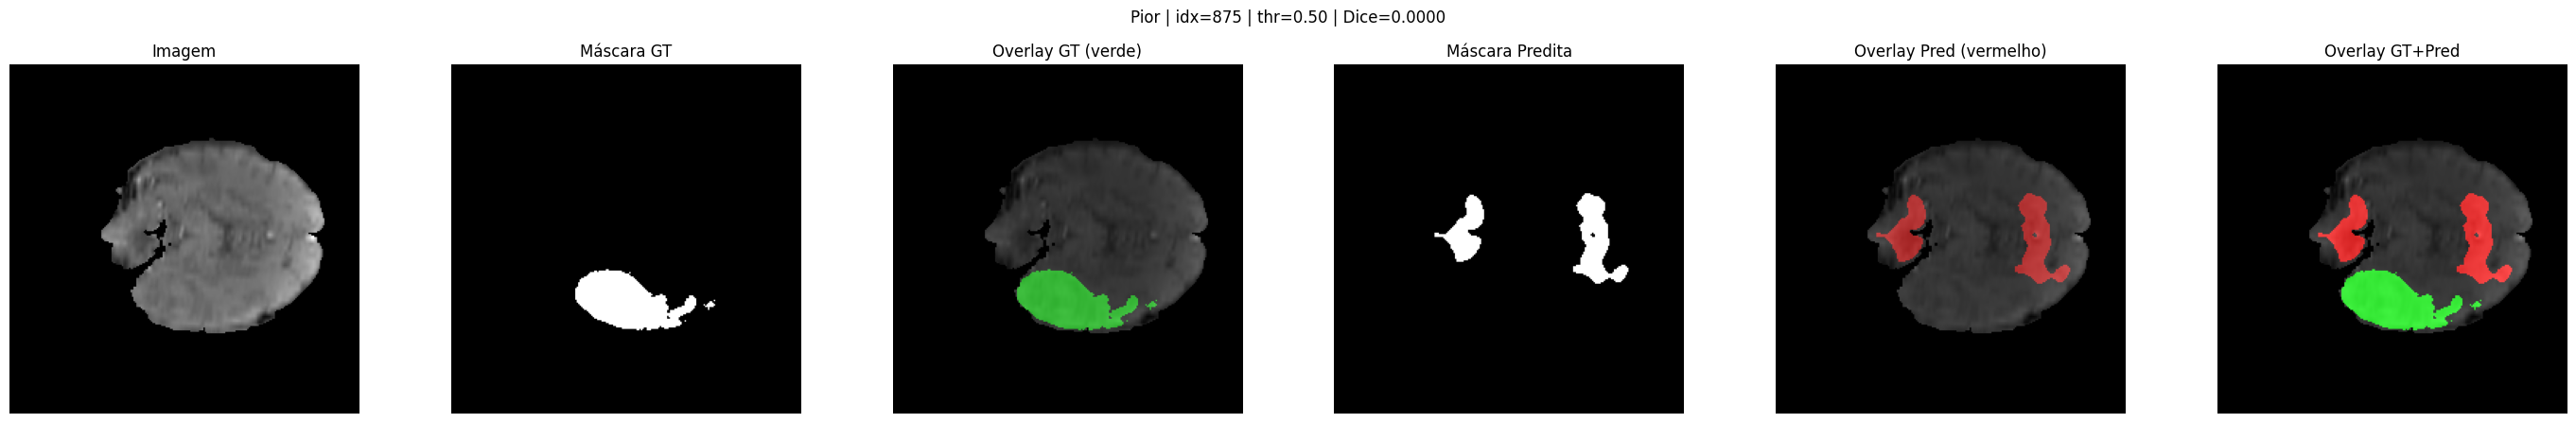

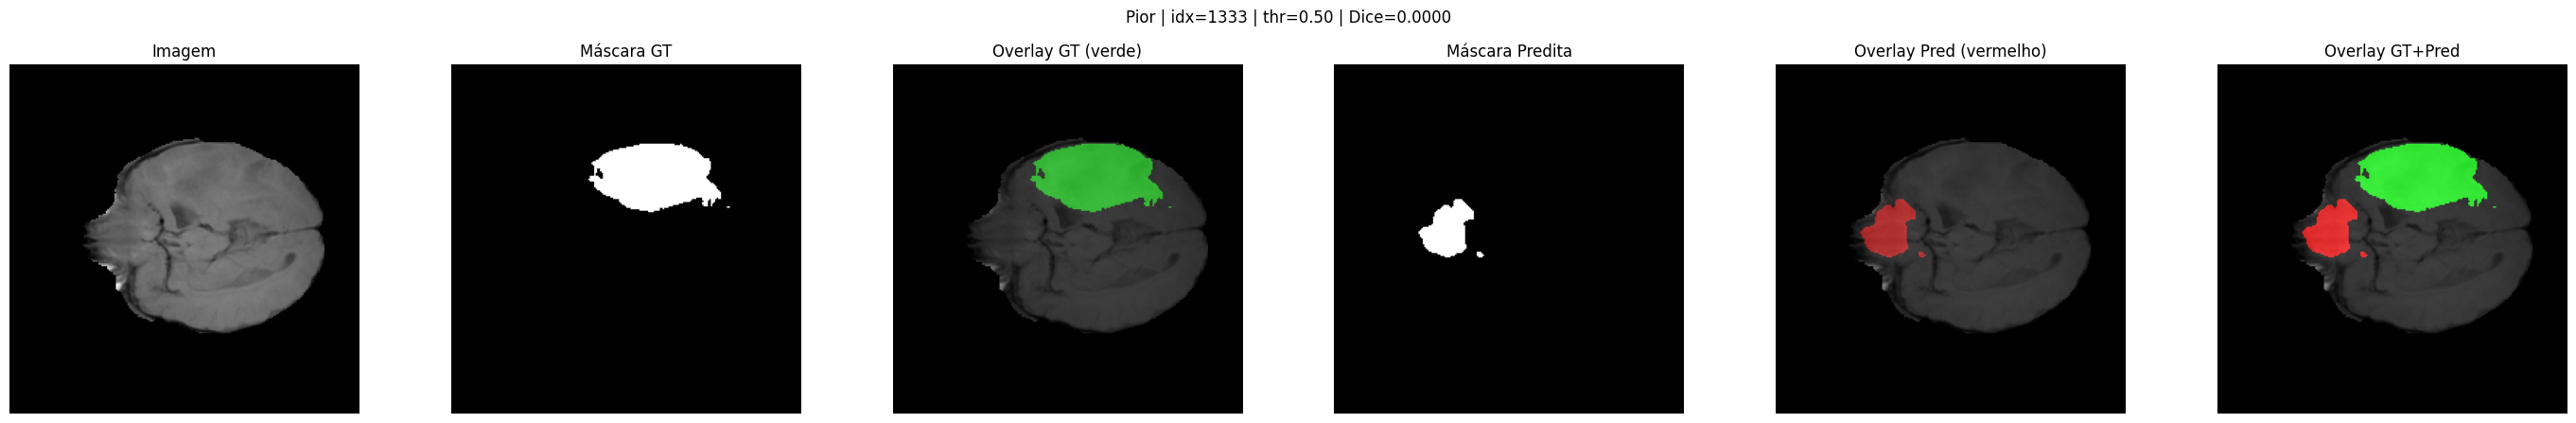

In [11]:
# Ranking e exibição (melhor, melhor, aleatório x4, pior, pior)
if 'results_sorted' not in globals() or len(results_sorted) == 0:
    results = []
    model.eval()
    with torch.no_grad():
        for idx in range(len(test_dataset)):
            im, gt = test_dataset[idx]
            im, gt = im.to(device), gt.to(device)
            logit = model(im.unsqueeze(0))
            d = dice_coeff_hard(logit, gt.unsqueeze(0), threshold=0.5, from_logits=True).item()
            results.append((idx, d))
    results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

best2  = results_sorted[:2] if len(results_sorted) >= 2 else results_sorted[:1]
worst2 = results_sorted[-2:] if len(results_sorted) >= 2 else results_sorted[-1:]

while len(best2)  < 2 and len(results_sorted) > 0: best2  += best2[:1]
while len(worst2) < 2 and len(results_sorted) > 0: worst2 += worst2[:1]

extreme_idxs = {i for i, _ in (best2 + worst2)}
pool = [i for i in range(len(test_dataset)) if i not in extreme_idxs]

if len(pool) >= 4:
    rand4 = random.sample(pool, 4)
elif len(pool) > 0:
    rand4 = [random.choice(pool) for _ in range(4)]
else:
    fallback = list(extreme_idxs) or [0]
    rand4 = [random.choice(fallback) for _ in range(4)]

order = [
    best2[0][0], best2[1][0],
    rand4[0], rand4[1], rand4[2], rand4[3],
    worst2[0][0], worst2[1][0],
]

labels = {
    best2[0][0]:  "Melhor",
    best2[1][0]:  "Melhor",
    worst2[0][0]: "Pior",
    worst2[1][0]: "Pior",
}

thr_val = BEST_THR if 'BEST_THR' in globals() else 0.5
print("Exibindo: Melhor, Melhor, Aleatório x4, Pior, Pior")

for idx in order:
    title = labels.get(idx, "Aleatório")

    im, gt = test_dataset[idx]
    with torch.no_grad():
        logit = model(im.unsqueeze(0).to(device))
        prob  = torch.sigmoid(logit).cpu()
    predb = (prob > thr_val).float()

    d = dice_coeff_hard(prob, gt.unsqueeze(0), threshold=thr_val, from_logits=False).item()

    overlay_gt_green = overlay_color(im, gt,               color=(0,1,0), alpha=0.5)
    overlay_pred_red = overlay_color(im, predb.squeeze(0), color=(1,0,0), alpha=0.5)
    overlay_combo    = overlay_both (im, gt, predb.squeeze(0))

    fig, axes = plt.subplots(1, 6, figsize=(28, 4), constrained_layout=True)
    fig.suptitle(f"{title} | idx={idx} | thr={thr_val:.2f} | Dice={d:.4f}", y=1.08)

    axes[0].imshow(im.squeeze(),  cmap="gray");                 axes[0].set_title("Imagem");                  axes[0].axis("off")
    axes[1].imshow(gt.squeeze(),  cmap="gray");                 axes[1].set_title("Máscara GT");              axes[1].axis("off")
    axes[2].imshow(overlay_gt_green);                           axes[2].set_title("Overlay GT (verde)");      axes[2].axis("off")
    axes[3].imshow(predb.cpu().squeeze().numpy(), cmap="gray"); axes[3].set_title("Máscara Predita");         axes[3].axis("off")
    axes[4].imshow(overlay_pred_red);                           axes[4].set_title("Overlay Pred (vermelho)"); axes[4].axis("off")
    axes[5].imshow(overlay_combo);                              axes[5].set_title("Overlay GT+Pred");         axes[5].axis("off")

    plt.show()


In [14]:
# Avaliação no baseline2020 - T1/Seg
model.eval()

metrics = {"dice": [], "iou": [], "acc": []}

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        logits = model(imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

        if preds.shape[-2:] != masks.shape[-2:]:
            preds = F.interpolate(preds, size=masks.shape[-2:], mode="nearest")

        dice = dice_coeff_hard(probs, masks, threshold=0.5, from_logits=False).item()
        iou = iou_hard(preds, masks, thr=0.5, from_logits=False).item()

        correct = (preds == masks).sum().item()
        total   = masks.numel()
        acc     = correct / total

        metrics["dice"].append(dice)
        metrics["iou"].append(iou)
        metrics["acc"].append(acc)

# Consolidar resultados em %
df_results = pd.DataFrame([{
    "Dice (%)": round(np.mean(metrics["dice"]) * 100, 2),
    "IoU (%)":  round(np.mean(metrics["iou"]) * 100, 2),
    "Acc (%)":  round(np.mean(metrics["acc"]) * 100, 2)
}])

display(df_results)

,Dice (%),IoU (%),Acc (%)
0,63.4,52.02,98.63
